### Deadline 23.01.2022

# Первая нейросетка

Ну что ж, пришло время построить свою первую нейронную сеть. У нас будет искуственная задачка и мы посмотрим на её примере, как работают различные алгоритмы машинного обучения.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('data.csv',index_col=0)

Как и в любой задаче машинного обучения для начала надо визуализировать данные. 
Не зря же нашу нейронную сеть мы так долго учим?


<AxesSubplot:xlabel='x1', ylabel='x2'>

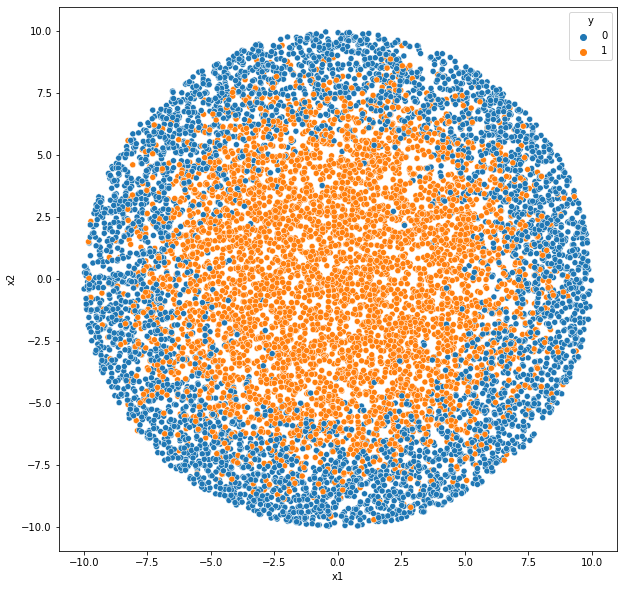

In [3]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x="x1", y="x2", hue="y", data = df)

In [4]:
df

,x1,x2,y
0,-4.626272,-6.658988,0
1,-7.789640,0.262519,0
2,-8.739678,1.537758,0
3,-2.546441,-7.705224,0
4,-2.751506,-7.940187,0
...,...,...,...
9995,-3.806339,0.794411,1
9996,3.592259,-1.130786,1
9997,-2.689095,-8.292189,1
9998,-9.470113,2.401624,0


После просмотра данных встает несколько вопросов:
 * 1) Можем ли мы построить идеальную модель ? (условная метрика точность)
 * 2) Что ещё мы хотим знать о выборке?
 * 3) Какие алгоритмы машинного обучения мы можем эффективно здесь использовать?

In [5]:
# 1. Кажется, нет, т.к. на глаз распределение данных не похоже на модельное
# 2. Хотим знать:
#       - распределение классов (0.5097 в пользу y=1)
#       - насколько распределение похоже на нормальное (без ответа пока что)
# 3. KNN, RandomForest

После описательного анализа приступим к построению моделей. Для начала посмотрим, что нам даст Логистическая регрессия. 

In [6]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score

# разобьем выборку на трэйн/тест
X_train, X_test, y_train, y_test = train_test_split(df[['x1','x2']], df['y'], test_size = 0.33, random_state = 12)

Точность нашей модели 0.5512121212121213


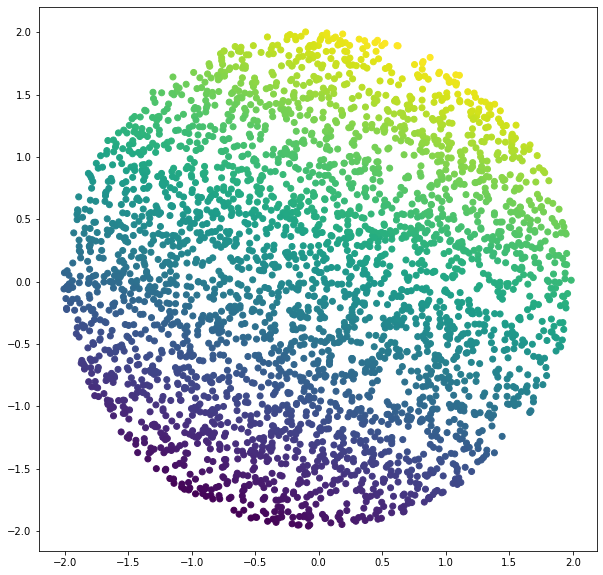

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train[['x1','x2']] = scaler.transform(X_train)
X_test[['x1','x2']] = scaler.transform(X_test)
model = LogisticRegression()

model.fit(X=X_train, y=y_train)

predict_logit =  model.predict(X=X_test)
predict_log_proba = model.predict_proba(X=X_test)



from sklearn.metrics import accuracy_score

print(f'Точность нашей модели {accuracy_score(predict_logit, y_test)}')

# Заодно завизуализируем полученные результаты
plt.figure(figsize=(10, 10))
plt.scatter(X_test['x1'], X_test['x2'], c = predict_log_proba[:,1])
plt.show()

Вообще машинное обучение не только про алгоритмы (нейронные сети не исключение),
 а скорее про обработку данных. Что нам надо добавить, чтобы наш алгоритм отработал без проблем?

In [8]:

# Повторяем наш код, только с новыми фичами - смотрим на магию
df_new = df.copy()
# новая фича - расстояние до центра
df_new['l'] = np.sqrt((df_new['x1'])**2+(df_new['x2'])**2)
# Точность нашей модели 0.8448484848484848


In [9]:
# заметим, что присутствует некоторая радиальная зависимость. Напишем функцию, считающую угол (от оси абсцисс по часовой стрелке) для каждой точки в градусах
import math
def angle(horiz,vert, l):
    if horiz > 0:
        result = math.acos(vert/l) * 180/math.pi
    else:
        result = 360 - math.acos(vert/l)*180/math.pi
    return result
angle_v = np.vectorize(angle)

# запишем углы в датасет
df_new['angle'] = angle_v(horiz = df_new['x1'], vert=df_new['x2'], l=df_new['l'])

#возьмём точки, для которых y=1
full_angles = df_new['angle'][df_new['y'] == 1] 

In [10]:
# заметим, что эта зависимость лучше проявляется, когда берём не 360 углов, а около 200
# plt.figure(figsize=(20, 10))
# plt.hist(full_angles,bins = 180)
# plt.show()

In [11]:
# сделаем 180 углов вместо 360
from sklearn.preprocessing import KBinsDiscretizer
discrete = KBinsDiscretizer(n_bins = 180, encode = 'ordinal',strategy = 'uniform')
df_new['effective_angles'] = discrete.fit_transform(df_new[['angle']])

# запишем список углов в отдельный массив
angles = np.array(np.unique(df_new['effective_angles']))

# посчитаем, какие углы как часто встречаютсяи
hist = np.unique(df_new[['effective_angles']], return_counts = True)

# для каждого из 180 секторов посчитаем "вероятность" попадания значения y=1 в этот сектор, как отношение числа единичек в этом секторе к максимально возможному
max_count = hist[1].max()
angle_weights = hist[1] / max_count

# соотнесём полученные вероятности для углов с каждым объектом массива в новом признаке
df_new['weights']=np.take(angle_weights,df_new['effective_angles'])

# нормализуем
df_new['weights']=scaler.fit_transform(df_new[['weights']])

# удалим ненужные больше столбцы
df_new.drop(['angle','effective_angles'],axis=1,inplace=True)

In [12]:
# функция, вычисляющая границу, перед которой 5% всех точек имеют y=1 (в центре - нули):
step = (df_new['l'].max() - df_new['l'].min())/100
start = df_new['l'].max()
border = df_new['l'].max()

def optimal_l_min(percent,step,border):
    ratio = 0
    while ratio < percent:
        ones =  df_new[(df_new['l']<border) & (df_new['y']==0)].shape[0]
        alls = df_new[df_new['l']<border].shape[0]
        ratio = ones / alls
        border += step
    print('optimal: ', border)
    return border
min_optimal_l = optimal_l_min(percent = 0.05,step=step, border=1)

# аналогичная отдельная функция, чтобы посчитать минимальную границу
def optimal_l_max(percent,step,border):
    ratio = 1
    while ratio > percent:
        zeros =  df_new[(df_new['l']>border) & (df_new['y']==0)].shape[0]
        alls = df_new[df_new['l']>border].shape[0]
        ratio = zeros / alls
        border -= step
    print('optimal: ', border)
    return border
# граница, за которой 95% всех точек точек имеют y=1:
max_optimal_l = optimal_l_max(percent = 0.95,step=step, border=9.9)

# создаём признаки
df_new['max_optimal_l'] = np.where(df_new['l']>max_optimal_l,1,0)
df_new['min_optimal_l'] = np.where(df_new['l']>min_optimal_l,1,0)
df_new


optimal:  6.042602810207797
optimal:  8.911254350939648


,x1,x2,y,l,weights,max_optimal_l,min_optimal_l
0,-4.626272,-6.658988,0,8.108299,-0.476809,0,1
1,-7.789640,0.262519,0,7.794062,1.088295,0,1
2,-8.739678,1.537758,0,8.873932,-2.302763,0,1
3,-2.546441,-7.705224,0,8.115100,0.044892,0,1
4,-2.751506,-7.940187,0,8.403413,0.044892,0,1
...,...,...,...,...,...,...,...
9995,-3.806339,0.794411,1,3.888355,-2.302763,0,0
9996,3.592259,-1.130786,1,3.766032,0.175318,0,0
9997,-2.689095,-8.292189,1,8.717318,0.827444,0,1
9998,-9.470113,2.401624,0,9.769895,0.044892,1,1


Точность нашей модели 0.8466666666666667


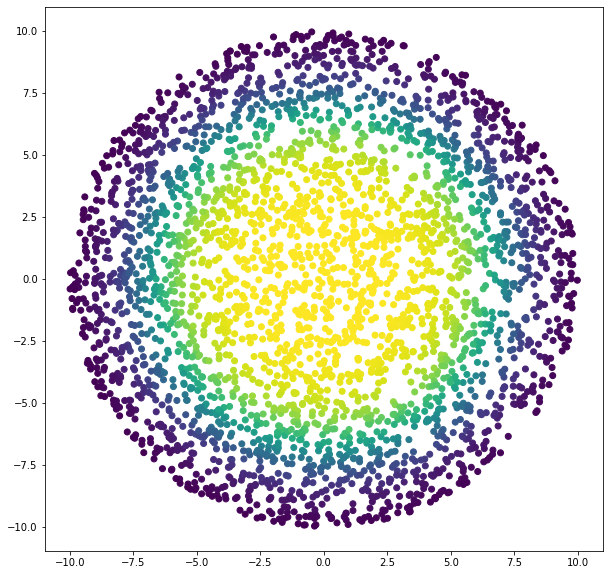

In [13]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(df_new[['x1', 'x2', 'l','weights','max_optimal_l','min_optimal_l']],
                                                                    df_new['y'], test_size = 0.33, random_state = 12)


# scaler = StandardScaler()
# scaler.fit(X_train_new[['x1','x2','l']])
# X_train_new[['x1','x2','l']] = scaler.transform(X_train_new[['x1','x2','l']])
# X_test_new[['x1','x2','l']] = scaler.transform(X_test_new[['x1','x2','l']])
# model = LogisticRegression()


model.fit(X=X_train_new, y=y_train_new)

predict_logit =  model.predict(X=X_test_new)
predict_log_proba = model.predict_proba(X=X_test_new)

#########################################

print(f'Точность нашей модели {accuracy_score(predict_logit,y_test_new)}')

plt.figure(figsize=(10, 10))
plt.scatter(X_test_new['x1'], X_test_new['x2'], c = predict_log_proba[:,1])
plt.show()


Переходим к следующиму классу алгоритмов - деревья решений. Какая особенность есть у деревьев? Какой параметр надо зафикисировать, чтобы эта особенность не испортила обучение? 

In [14]:
# особенность - склонность к переобучению
# параметр для фиксации - максимальная глубина дерева

Точность нашей модели 0.8445454545454546


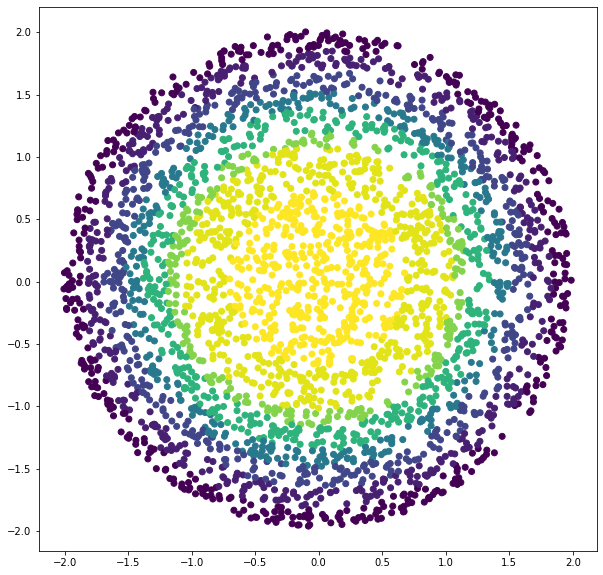

In [15]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(criterion = 'entropy',max_depth = 3, random_state=12)
model.fit(X_train_new, y_train_new)
predict_tree = model.predict(X_test_new)
print(f'Точность нашей модели {accuracy_score(predict_tree, y_test)}')

predict_tree_proba = model.predict_proba(X=X_test_new)

# #########################################

plt.figure(figsize=(10,10))
plt.scatter(X_test['x1'], X_test['x2'], c = predict_tree_proba[:,1])
plt.show()

In [16]:
predict_tree_proba

array([[0.76111686, 0.23888314],
       [0.34248366, 0.65751634],
       [0.18080357, 0.81919643],
       ...,
       [0.57386364, 0.42613636],
       [0.96194503, 0.03805497],
       [0.76111686, 0.23888314]])

Поможет ли в данном случае ансамблирование? Когда в целом ансамбль дает хорошие результаты?

Точность нашей модели 0.8445454545454546


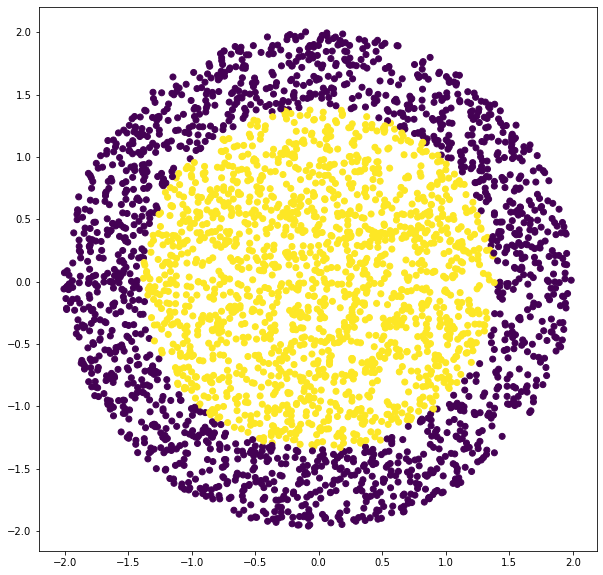

In [60]:
# ансамблирование не поможет. Случайный лес скругляет границы области решений, что в данном случае не полезно.
# 

from sklearn.ensemble import RandomForestClassifier


model = RandomForestClassifier(criterion = 'gini',max_depth=5,min_samples_leaf=1)
model.fit(X_train_new, y_train_new)

predict_forest = model.predict(X_test_new)

print(f'Точность нашей модели {accuracy_score(predict_forest, y_test_new)}')

predict_forest_proba = predict_forest

#########################################

plt.figure(figsize=(10, 10))
plt.scatter(X_test['x1'], X_test['x2'], c = predict_forest_proba)
plt.show()

ну и наконец мы добрались до нейронок - пора собрать нашу нейроночку под эту задачу.

Соберем простенькую нейронку - нам хватит 2х слоев по 5 нейронов в каждом. Смотрим на предыдущую тетрадку и копипастим все, что мы там видим! (можно для убыстрения процесса добавить callback с ранней остановкой)

In [82]:
# Подгружаем tensorflow 
import tensorflow as tf
keras = tf.keras

print(tf.__version__)
print(keras.__version__) 

from tensorflow.keras.models import Sequential   # Последовательность слоёв
import tensorflow.keras.layers as L              # Разные слои
import tensorflow.keras.optimizers as opt        # Оптимизаторы
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping


2.9.1
2.9.0


In [94]:
from tensorflow.keras.metrics import Accuracy

def get_new_model( ):
    acc = Accuracy()


    model = Sequential(name = 'Homework_1')  # модели можно дать имя!
    
    # Добавляем в нашу модель первый слой из 25 нейронов
    model.add(L.Dense(25, input_dim = X_train_new.shape[1], kernel_initializer='random_normal'))

    # Добавляем функцию активации на первый слой 
    model.add(L.Activation('sigmoid'))

    # Добавляем ещё один слой из 25 нейронов
    model.add(L.Dense(25, kernel_initializer='random_normal'))
    model.add(L.Activation('sigmoid'))

    # На выходе мы должны получить вероятности того, что объект относится к разным классам 
    # Сделать такое преобразование позволяет softmax как функция активации
    # На выход будет идти 4 вероятности по числу классов
    model.add(L.Dense(2, activation='softmax', kernel_initializer = 'random_normal'))
    
    ###########################################################
    
    # В качестве оптимизации будем использовать Adam
    # Это такой специальный градиентный спуск, обсудим его в следущий раз
    optimizer = opt.Adam(learning_rate=1e-3)

    custom_loss = tf.keras.losses.BinaryFocalCrossentropy(
    gamma=1.5,
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    name='binary_focal_crossentropy' 
    )

    # Собираем модель
    model.compile(loss = custom_loss, 
                  metrics=['acc'], 
                  optimizer=optimizer)
    
    return model


In [95]:

model = get_new_model()
model.summary()
callback = EarlyStopping(monitor='loss',
    min_delta=0.001,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False)


Model: "Homework_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 25)                175       
                                                                 
 activation_32 (Activation)  (None, 25)                0         
                                                                 
 dense_49 (Dense)            (None, 25)                650       
                                                                 
 activation_33 (Activation)  (None, 25)                0         
                                                                 
 dense_50 (Dense)            (None, 2)                 52        
                                                                 
Total params: 877
Trainable params: 877
Non-trainable params: 0
_________________________________________________________________


In [96]:
hist = model.fit(X_train_new, to_categorical(y_train_new), validation_split=0.2, epochs=30, verbose=1, batch_size=128,callbacks=[callback])
# hist = model.fit(X_train_new, to_categorical(y_train_new), validation_split=0.2, epochs=30, verbose=1, batch_size=128)


Epoch 1/30
42/42 [==============================] - 2s 19ms/step - loss: 0.2448 - acc: 0.5114 - val_loss: 0.2444 - val_acc: 0.5037
Epoch 2/30
42/42 [==============================] - 0s 9ms/step - loss: 0.2435 - acc: 0.5422 - val_loss: 0.2418 - val_acc: 0.7478
Epoch 3/30
42/42 [==============================] - 0s 8ms/step - loss: 0.2382 - acc: 0.7705 - val_loss: 0.2329 - val_acc: 0.7963
Epoch 4/30
42/42 [==============================] - 0s 8ms/step - loss: 0.2222 - acc: 0.8028 - val_loss: 0.2092 - val_acc: 0.8284
Epoch 5/30
42/42 [==============================] - 0s 9ms/step - loss: 0.1899 - acc: 0.8093 - val_loss: 0.1729 - val_acc: 0.8007
Epoch 6/30
42/42 [==============================] - 0s 9ms/step - loss: 0.1572 - acc: 0.8129 - val_loss: 0.1482 - val_acc: 0.8007
Epoch 7/30
42/42 [==============================] - 0s 7ms/step - loss: 0.1402 - acc: 0.8147 - val_loss: 0.1387 - val_acc: 0.8269
Epoch 8/30
42/42 [==============================] - 0s 9ms/step - loss: 0.1347 - acc: 0.8

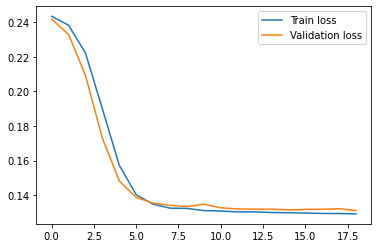

In [97]:
start = 1
plt.plot(hist.history['loss'][start:])
plt.plot(hist.history['val_loss'][start:])
plt.legend(['Train loss', 'Validation loss'])

104/104 [==============================] - 0s 3ms/step
Точность нашей модели 0.8406060606060606


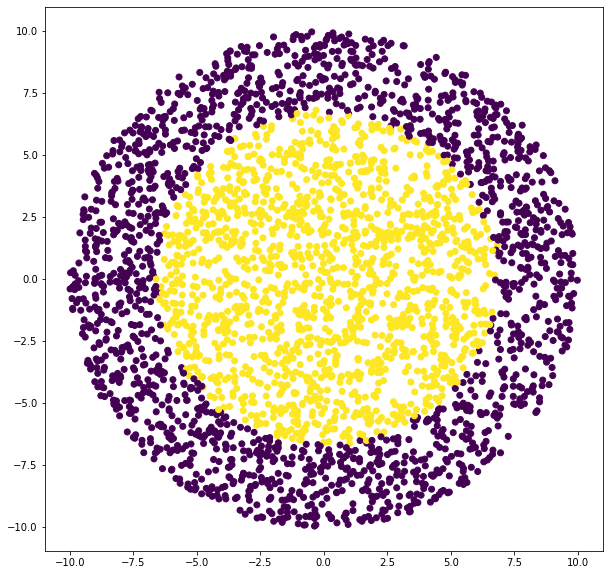

In [98]:

predict_neural = model.predict(X_test_new)

predict_classes = tf.argmax(model.predict(X_test_new), axis=1)

print(f'Точность нашей модели {accuracy_score(predict_classes, y_test_new)}')
#########################################

plt.figure(figsize=(10, 10))
plt.scatter(X_test_new['x1'], X_test_new['x2'], c = predict_classes)
plt.show()

На этом наше приключение сегодня закончилось. Вопросы максимально желательны :)